### Imports

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler

___
### EDA and preprocessing

In [65]:
# Read in our data
df1 = pd.read_csv('../data/existentialism.csv')
df2 = pd.read_csv('../data/nihilism.csv')
df = pd.read_csv('../data/total.csv')

In [66]:
# Before we start fitting models, we will first explore our data
# First, we will add columns which track how many words and characters there are in a post

df['char_length'] = df['text'].apply(lambda x: len(str(x)))
df['word_length'] = df['text'].apply(lambda x: len(str(x).split()))
df.head()

,time,title,text,type,char_length,word_length
0,1.704666e+09,Subjectivity is the Starting Point,"*The word subjectivism has two meanings, and o...",1,1441,229
1,1.704665e+09,Is there a possibility of an afterlife?,Title,1,5,1
2,1.704575e+09,The meaning of existence,\n\nI had a discussion with friend who is an ...,1,1683,307
3,1.704481e+09,the mind and the notion of the self,Quite a while ago i came up with this Idea abo...,1,1510,238
4,1.704472e+09,I made an ambient album based on my initial in...,NaN,1,3,1


In [67]:
# We see a lot of empty values, implying the text post is blank
# This probably corresponds to posts with a title and a picture so we will combine text and title

print(df['char_length'].value_counts())
print(df['word_length'].value_counts())

3       2993
50        27
1         22
49        21
48        20
        ... 
278        1
290        1
306        1
346        1
2039       1
Name: char_length, Length: 1498, dtype: int64
1       3090
2         66
10        56
8         55
5         54
        ... 
629        1
725        1
733        1
829        1
1839       1
Name: word_length, Length: 567, dtype: int64


In [68]:
# Combine those two columns
df['total'] = df['title'] + ' ' + df['text']

# Make char_length and word_length for total 
df['total_char'] = df['total'].apply(lambda x: len(str(x)))
df['total_word'] = df['total'].apply(lambda x: len(str(x).split()))

df.head()

,time,title,text,type,char_length,word_length,total,total_char,total_word
0,1.704666e+09,Subjectivity is the Starting Point,"*The word subjectivism has two meanings, and o...",1,1441,229,Subjectivity is the Starting Point *The word s...,1476,234
1,1.704665e+09,Is there a possibility of an afterlife?,Title,1,5,1,Is there a possibility of an afterlife? Title,45,8
2,1.704575e+09,The meaning of existence,\n\nI had a discussion with friend who is an ...,1,1683,307,The meaning of existence \n\nI had a discussi...,1708,311
3,1.704481e+09,the mind and the notion of the self,Quite a while ago i came up with this Idea abo...,1,1510,238,the mind and the notion of the self Quite a wh...,1546,246
4,1.704472e+09,I made an ambient album based on my initial in...,NaN,1,3,1,NaN,3,1


In [69]:
# Value counts, looks good
print(df['total_char'].value_counts())
print(df['total_word'].value_counts())

3       2995
411       17
119       16
155       15
69        15
        ... 
2224       1
2248       1
1010       1
4307       1
2599       1
Name: total_char, Length: 1529, dtype: int64
1       2993
18        62
17        53
11        51
30        47
        ... 
912        1
832        1
271        1
766        1
1827       1
Name: total_word, Length: 574, dtype: int64


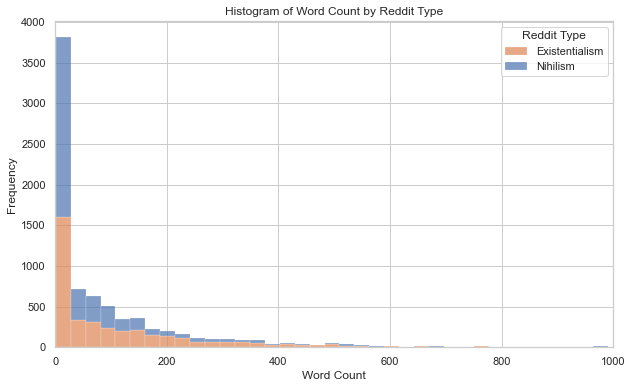

In [70]:
# It would help to see a distribution of char_length and word_length by type
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df, x='total_word', hue='type', bins=250, alpha=0.7, multiple="stack")

ax.set_xlim(0, 1000) # Only show values on the high relative frequency end

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count by Reddit Type')

ax.legend(title='Reddit Type', labels=['Existentialism', 'Nihilism'])
plt.savefig('../images/wordcount.png')

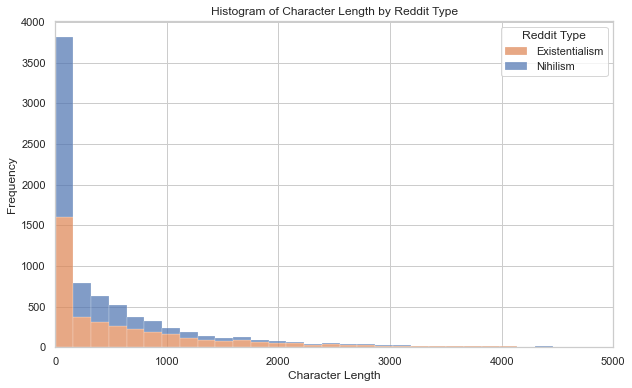

In [71]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df, x='total_char', hue='type', bins=250, alpha=0.7, multiple="stack")

ax.set_xlim(0, 5000) # Only show values on the high relative frequency end

plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.title('Histogram of Character Length by Reddit Type')

ax.legend(title='Reddit Type', labels=['Existentialism', 'Nihilism'])
plt.savefig('../images/charlength.png')

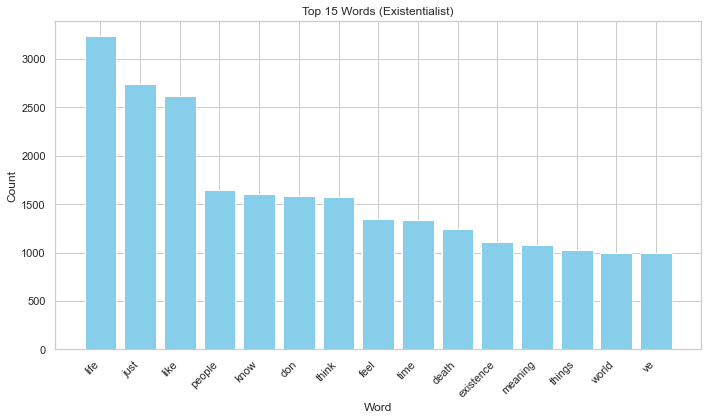

In [72]:
# Next we will look at the 15 most common words for each of the subreddits 
# First the existentialist subreddit
df1['combined'] = df1['title'].fillna('') + ' ' + df1['text'].fillna('')

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df1['combined'].astype(str))

word_counts_df = pd.DataFrame({'Word': vectorizer.get_feature_names_out(), 'Count': X.sum(axis=0).A1})

word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(word_counts_df['Word'][:15], word_counts_df['Count'][:15], color='skyblue')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 15 Words (Existentialist)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('../images/top_15_existentialist.png')

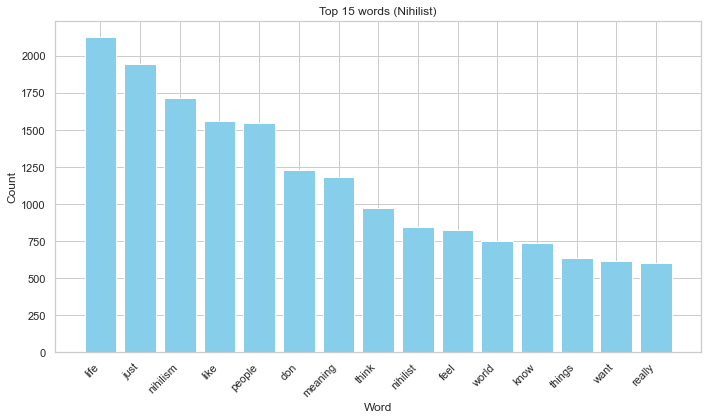

In [73]:
# Next the nihilist subreddit
df2['combined'] = df2['title'].fillna('') + ' ' + df2['text'].fillna('')

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df2['combined'].astype(str))

word_counts_df = pd.DataFrame({'Word': vectorizer.get_feature_names_out(), 'Count': X.sum(axis=0).A1})

word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(word_counts_df['Word'][:15], word_counts_df['Count'][:15], color='skyblue')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 15 words (Nihilist)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('../images/top_15_nihilist.png')

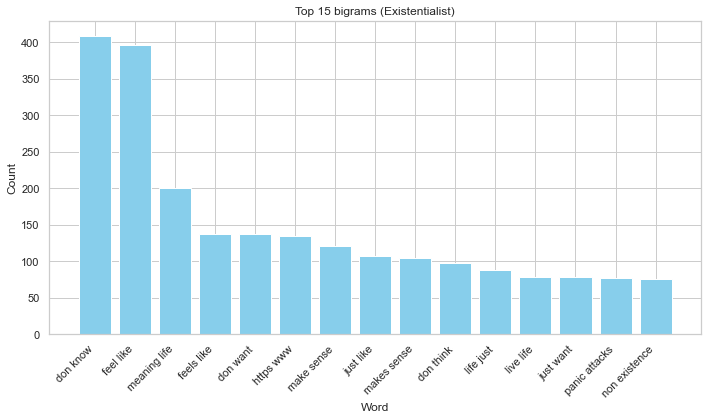

In [74]:
# Now lets get the top 15 most common bigrams for each
# First existentialism
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df1['combined'].astype(str))

word_counts_df = pd.DataFrame({'Word': vectorizer.get_feature_names_out(), 'Count': X.sum(axis=0).A1})

word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(word_counts_df['Word'][:15], word_counts_df['Count'][:15], color='skyblue')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 15 bigrams (Existentialist)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('../images/top_15_existentialist2.png')

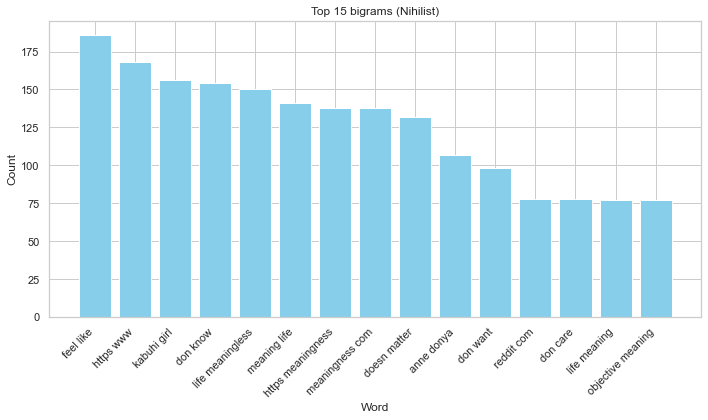

In [75]:
# Bigrams for nihilist subreddit
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df2['combined'].astype(str))

word_counts_df = pd.DataFrame({'Word': vectorizer.get_feature_names_out(), 'Count': X.sum(axis=0).A1})

word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(word_counts_df['Word'][:15], word_counts_df['Count'][:15], color='skyblue')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 15 bigrams (Nihilist)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('../images/top_15_nihilist2.png')

___
### Baseline Accuracy

In [76]:
# Before we start modeling, we should look at our baseline accuracy
# Baseline accuracy is bascally 50%

df['type'].value_counts(normalize = True)

0    0.501767
1    0.498233
Name: type, dtype: float64

___
### Count Vectorizer model

In [77]:
df.head()

,time,title,text,type,char_length,word_length,total,total_char,total_word
0,1.704666e+09,Subjectivity is the Starting Point,"*The word subjectivism has two meanings, and o...",1,1441,229,Subjectivity is the Starting Point *The word s...,1476,234
1,1.704665e+09,Is there a possibility of an afterlife?,Title,1,5,1,Is there a possibility of an afterlife? Title,45,8
2,1.704575e+09,The meaning of existence,\n\nI had a discussion with friend who is an ...,1,1683,307,The meaning of existence \n\nI had a discussi...,1708,311
3,1.704481e+09,the mind and the notion of the self,Quite a while ago i came up with this Idea abo...,1,1510,238,the mind and the notion of the self Quite a wh...,1546,246
4,1.704472e+09,I made an ambient album based on my initial in...,NaN,1,3,1,NaN,3,1


In [78]:
# Now we will fit our first model, count vectorizer
df['total'] = df['total'].fillna('')

X = df['total']
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

pipe = Pipeline([
    ('cvec', CountVectorizer(ngram_range = (1, 2))),
    ('lr', LogisticRegression(max_iter = 1000))
])

pipe_params = {
    'cvec__max_features': [1000, 2000, 8000],
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df': [2, 4],
    'cvec__max_df': [1.0, 0.8, 0.5],
    'lr__penalty': ['l2', None]
}

gs_1 = GridSearchCV(pipe, param_grid=pipe_params, cv = 5, n_jobs=-1)

gs_1.fit(X_train, y_train)
print(gs_1.best_params_)

{'cvec__max_df': 1.0, 'cvec__max_features': 8000, 'cvec__min_df': 4, 'cvec__stop_words': None, 'lr__penalty': 'l2'}


0.7718324078748107


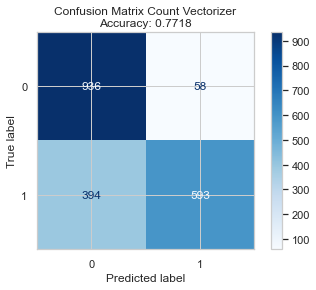

In [79]:
# A confusion matrix to visualise the performance
# Accuracy is 77.18% which is twice as good as baseline

pred_1 = gs_1.predict(X_test)
cm_1 = confusion_matrix(y_test, pred_1)
accuracy_1 = accuracy_score(y_test, pred_1)
print(accuracy_1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=gs_1.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix Count Vectorizer\nAccuracy: {accuracy_1:.4f}')
plt.savefig('../images/CMcvec.png')

In [80]:
# Check the top 10 most significant words in the model
best_model = gs_1.best_estimator_

lr_model = best_model.named_steps['lr']
cvec_model = best_model.named_steps['cvec']

feature_names = cvec_model.get_feature_names_out()

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_model.coef_[0]})

significant_words = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)
print(significant_words.head(15))

             Feature  Coefficient
4387        nihilist    -2.511796
2158  existentialism     2.432151
4373        nihilism    -2.391037
2151     existential     1.855653
4393       nihilists    -1.812911
2161  existentialist     1.705587
4392      nihilistic    -1.675366
1163           camus     1.123289
5545          sartre     1.100492
7000          to see     1.006619
1660      depression    -1.004199
6413        the more     0.823003
1154          called    -0.821431
1596              de     0.820829
4109        memories     0.809679


___
### TF-IDF Vectorizer Model

In [81]:
# Next we will try TF-IDF vectorizer which considers more than just word frequency

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('lr', LogisticRegression(max_iter=1000))
])

pipe_params = {
    'tfidf__max_features': [1000, 2000, 8000],
    'tfidf__stop_words': [None, 'english'],
    'tfidf__min_df': [2, 4],
    'tfidf__max_df': [1.0, 0.8, 0.5],
    'lr__penalty': ['l2', None]
}

gs_2 = GridSearchCV(pipe, param_grid=pipe_params, cv = 5, n_jobs=-1)
gs_2.fit(X_train, y_train)

print(gs_2.best_params_)

{'lr__penalty': None, 'tfidf__max_df': 0.5, 'tfidf__max_features': 8000, 'tfidf__min_df': 4, 'tfidf__stop_words': None}


0.7783947501261989


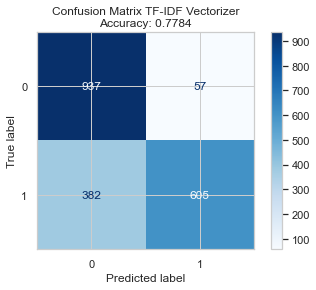

In [82]:
# Make confusion matrix to visualize model performance
pred_2 = gs_2.predict(X_test)
cm_2 = confusion_matrix(y_test, pred_2)
accuracy_2 = accuracy_score(y_test, pred_2)
print(accuracy_2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=gs_2.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix TF-IDF Vectorizer\nAccuracy: {accuracy_2:.4f}')
plt.savefig('../images/CMTFIDF.png')

# Test accuracy is 77.84% which is basically the same as count vectorizer

In [83]:
# Show top words from this model 
feature_names = gs_2.best_estimator_.named_steps['tfidf'].get_feature_names_out()
coefficients = gs_2.best_estimator_.named_steps['lr'].coef_[0]

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

top_words = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index).head(15)

print(top_words)

                Feature    Coefficient
2158     existentialism  122374.285111
4387           nihilist -120958.235668
4373           nihilism -120761.849736
4393          nihilists  -81645.251891
2151        existential   81522.436680
2161     existentialist   68104.655087
4392         nihilistic  -63832.460486
5545             sartre   45926.551594
1163              camus   41178.123474
2160  existentialism is   39278.061317
4380        nihilism is  -34385.300461
1228               care  -33446.228811
7876            you are  -33383.766665
1660         depression  -32216.560384
2298              feels   31677.363707


___
### Multinomial Naive Bayes

0.7314487632508834


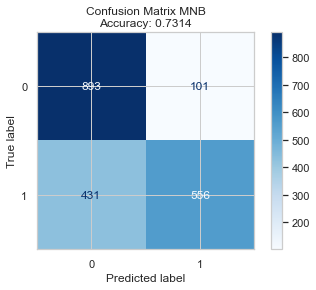

In [84]:
X = df['total']
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipe = Pipeline([
    ('count_vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('Bayes', MultinomialNB())
])

pipe_params = {
    'count_vectorizer__max_features': [1000, 2000, 8000],
    'count_vectorizer__stop_words': [None, 'english'],
    'count_vectorizer__min_df': [2, 4],
    'count_vectorizer__max_df': [1.0, 0.8, 0.5],
    'Bayes__alpha': [1.0, 0.5, 0.1],  
}

gs_3 = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs=-1)
gs_3.fit(X_train, y_train)

# Make confusion matrix to visualize model performance
pred_3 = gs_3.predict(X_test)
cm_3 = confusion_matrix(y_test, pred_3)
accuracy_3 = accuracy_score(y_test, pred_3)
print(accuracy_3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=gs_3.classes_)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix MNB\nAccuracy: {accuracy_3:.4f}')
plt.savefig('../images/CMMNB.png')


# Test accuracy is 73.14% which is the lowest accuracy so far

___ 
### Model Selection

In [85]:
# The TFIDF vectorizer has the highest accuracy but we should look at the classification report for each model to help decide 
# The MNB model was pretty poor so we will just consider the report for count vectorizer and TFIDF

In [86]:
y_pred_1 = gs_1.predict(X_test)
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.70      0.94      0.81       994
           1       0.91      0.60      0.72       987

    accuracy                           0.77      1981
   macro avg       0.81      0.77      0.76      1981
weighted avg       0.81      0.77      0.76      1981



In [87]:
y_pred_2 = gs_2.predict(X_test)
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.71      0.94      0.81       994
           1       0.91      0.61      0.73       987

    accuracy                           0.78      1981
   macro avg       0.81      0.78      0.77      1981
weighted avg       0.81      0.78      0.77      1981



In [88]:
# We see that TFIDF did the best not just in terms of accuracy but also recall
# Precision was about the same
# We will move forward with TFIDF model then

___
### Add Predictors

In [89]:
# Before we add predictors, we will look at the average word count for each reddit to see if there is a dfference
# We see a big dfference implying this could be a great predictor 
df.groupby('type')['total_word'].mean()

type
0     75.917254
1    128.497974
Name: total_word, dtype: float64

In [90]:
# Now the sentiment analysis score
def calculate_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment'] = df['total'].apply(calculate_sentiment)

df.groupby('type')['sentiment'].mean()

# Both are pretty close to neutral 

type
0    0.027291
1    0.047883
Name: sentiment, dtype: float64

In [91]:
# Out of our three models, we have chosen TFIDF with best params
# Now we will make a new dataframe with TFIDF transforming the text column along with two more columns; one for text word count
# and one for text sentiment analysis score
X = df[['text', 'total_word', 'sentiment']]
y = df['type']

# Handling missing values in the 'text' column by filling NaNs with an empty string
X['text'].fillna('', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# First, we transform text using TFIDF
vectorizer = TfidfVectorizer(max_df=4, max_features=8000, min_df=1, stop_words=None)

X_tvec = vectorizer.fit_transform(X_train['text'])

feature_names = vectorizer.get_feature_names_out()
dfv = pd.DataFrame(X_tvec.toarray(), columns=feature_names)

# Now we add the text word count column
scaler = StandardScaler()
dfv['word_count'] = scaler.fit_transform(X_train[['total_word']])

# Next, the sentiment analysis column
dfv['sentiment'] = X_train['text'].apply(calculate_sentiment)

/Users/tannerzuleeg/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [92]:
# We see some NaNs so we make them zero
dfv['sentiment'].fillna(0, inplace=True)

In [93]:
lgr = LogisticRegression(penalty = None, max_iter = 1000)
lgr.fit(dfv, y_train)

LogisticRegression(max_iter=1000, penalty=None)

In [94]:
df.head()

,time,title,text,type,char_length,word_length,total,total_char,total_word,sentiment
0,1.704666e+09,Subjectivity is the Starting Point,"*The word subjectivism has two meanings, and o...",1,1441,229,Subjectivity is the Starting Point *The word s...,1476,234,-0.038952
1,1.704665e+09,Is there a possibility of an afterlife?,Title,1,5,1,Is there a possibility of an afterlife? Title,45,8,0.000000
2,1.704575e+09,The meaning of existence,\n\nI had a discussion with friend who is an ...,1,1683,307,The meaning of existence \n\nI had a discussi...,1708,311,-0.011384
3,1.704481e+09,the mind and the notion of the self,Quite a while ago i came up with this Idea abo...,1,1510,238,the mind and the notion of the self Quite a wh...,1546,246,0.021250
4,1.704472e+09,I made an ambient album based on my initial in...,NaN,1,3,1,,3,1,0.000000


In [95]:
X_ttvec = vectorizer.transform(X_test['text'])

feature_names = vectorizer.get_feature_names_out() 
dfv_test = pd.DataFrame(X_ttvec.toarray(), columns=feature_names)

# Now we add the text word count column
dfv_test['word_count'] = scaler.transform(X_test[['total_word']])

dfv_test['sentiment'] = df['total'].apply(calculate_sentiment)

In [96]:
# Accuracy
y_pred = lgr.predict(dfv_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# We see that the accuracy went down by adding these predictors

0.663301362948006
